In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.metrics import r2_score , mean_squared_error , mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV 
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_excel("premiums_young.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857


In [3]:
df.shape

(20096, 13)

## 1). Data Cleaning & EDA

In [4]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

In [5]:
df.columns = df.columns.str.replace(' ' , '_').str.lower()

In [6]:
df.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857


### Handle NA Values

In [7]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [8]:
df.dropna(inplace = True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [9]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

### Handle Outliers

In [10]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


In [11]:
df[df.number_of_dependants < 0].shape

(22, 13)

In [12]:
df[df.number_of_dependants < 0]['number_of_dependants'].unique()

array([-3, -1], dtype=int64)

In [13]:
# 'number_of_dependants' column contain -3 and -1 values for 72 rows

In [14]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

In [15]:
numeric_columns = df.select_dtypes(['float64' , 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

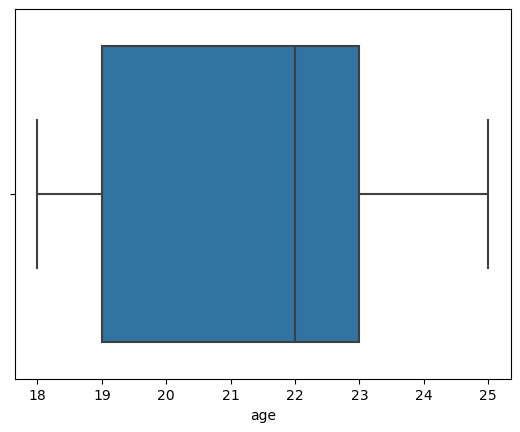

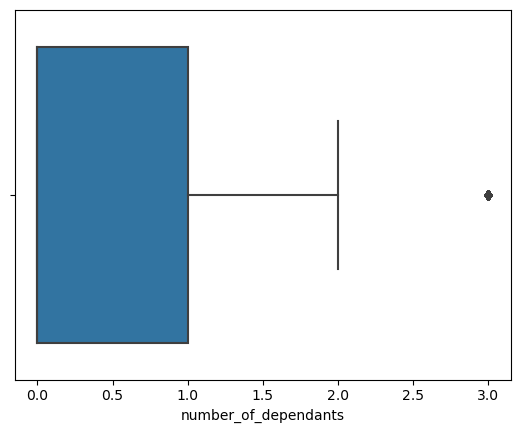

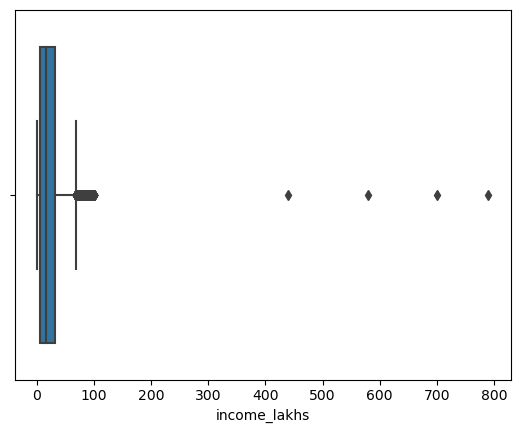

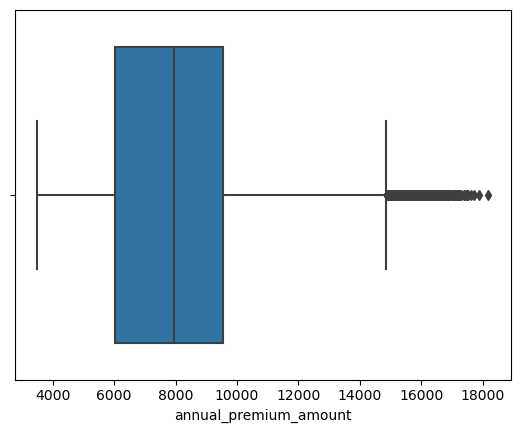

In [16]:
for col in numeric_columns:
    sns.boxplot(x = df[col])
    plt.show()

In [17]:
df[df.age > 100]['age'].unique()

array([], dtype=int64)

In [18]:
df1 = df[df.age <=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


In [19]:
df1.income_lakhs.quantile([0.25 , 0.75])

0.25     6.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [20]:
def get_iqr_bounds(col):
    Q1 , Q3 = col.quantile([0.25 , 0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound , upper_bound
    

In [21]:
get_iqr_bounds(df1.income_lakhs)

(-31.5, 68.5)

In [22]:
quantile_thresold = df1.income_lakhs.quantile(0.999)
quantile_thresold

100.0

In [23]:
df1[df1.income_lakhs > quantile_thresold].shape

(4, 13)

In [24]:
df2 = df1[df1.income_lakhs <= quantile_thresold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263
std,2.294248,0.937238,21.732062,2749.912486
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.000000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,100.000000,18186.000000


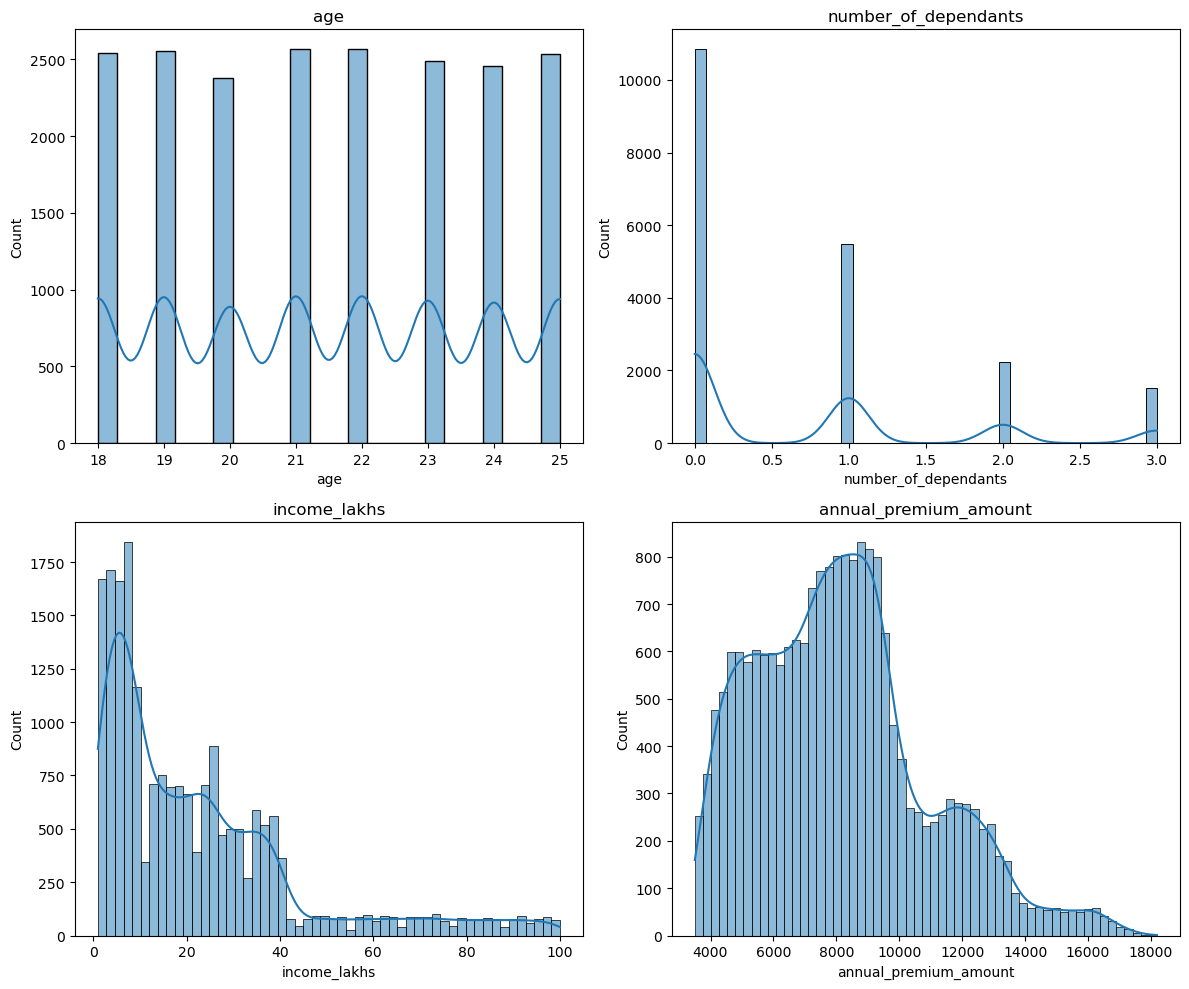

In [25]:


fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 subplot grid
axes = axes.flatten()  # Flatten to make indexing easier

for i, col in enumerate(numeric_columns):
    sns.histplot(df2[col], kde=True, ax=axes[i])  # Assign each plot to a subplot
    axes[i].set_title(col)  # Add column name as title
    

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

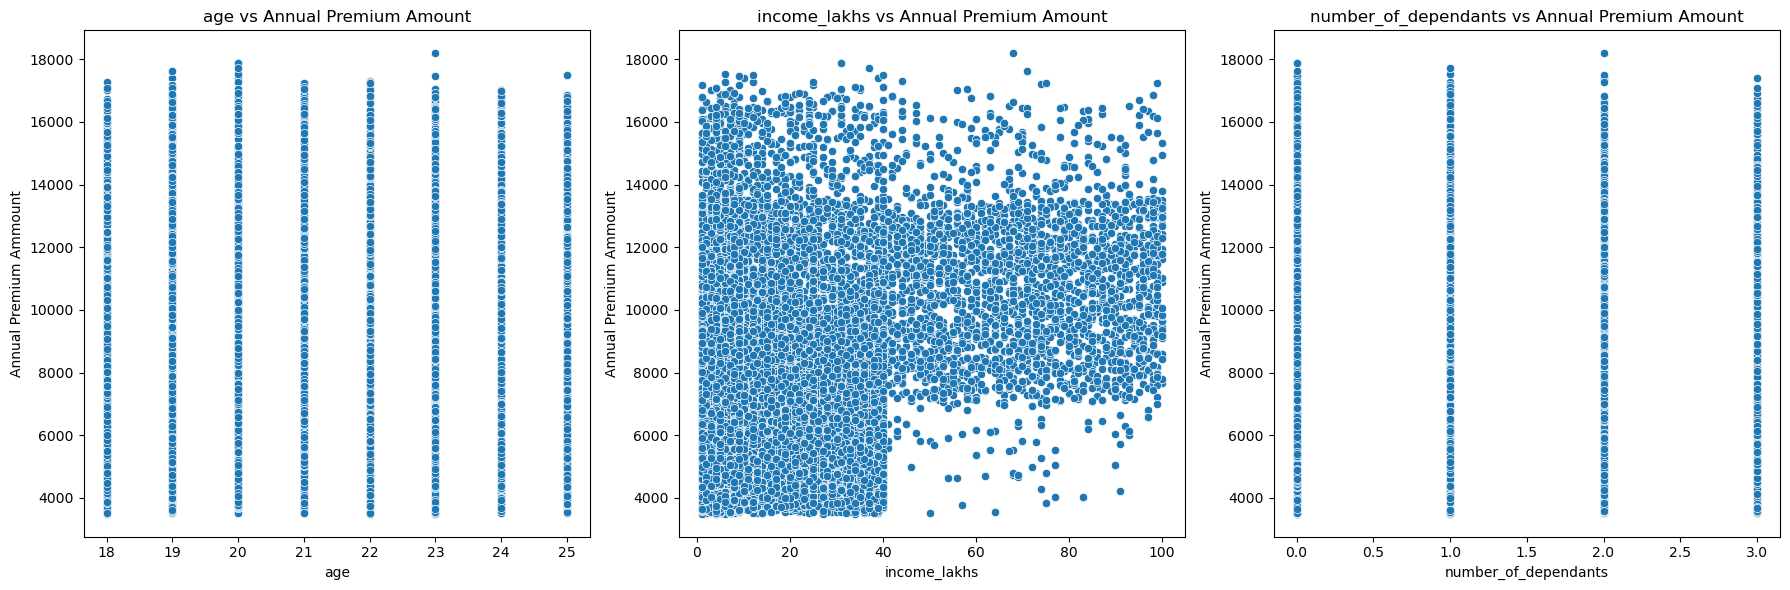

In [26]:
numeric_features = ['age' , 'income_lakhs' , 'number_of_dependants']

fig , axes = plt.subplots(1 , len(numeric_features) , figsize = (18,6))
axes = axes.flatten()

for i , column in enumerate(numeric_features):
    sns.scatterplot(x = df2[column] , y = df2["annual_premium_amount"] , ax= axes[i])
    axes[i].set_title(f'{column} vs Annual Premium Amount')   
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Annual Premium Ammount")
    
plt.tight_layout()
plt.show()                

In [27]:
categorical_cols = df.select_dtypes(['object' , 'category']).columns
categorical_cols

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [28]:
for col in categorical_cols:
    print(col , ":" , df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [29]:
df2['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Does Not Smoke' : 'No Smoking',
    'Not Smoking' : 'No Smoking'
    
} , inplace = True)
df2['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [30]:
pct_count = df2['gender'].value_counts(normalize = True)
pct_count

gender
Male      0.550383
Female    0.449617
Name: proportion, dtype: float64

<Axes: xlabel='gender'>

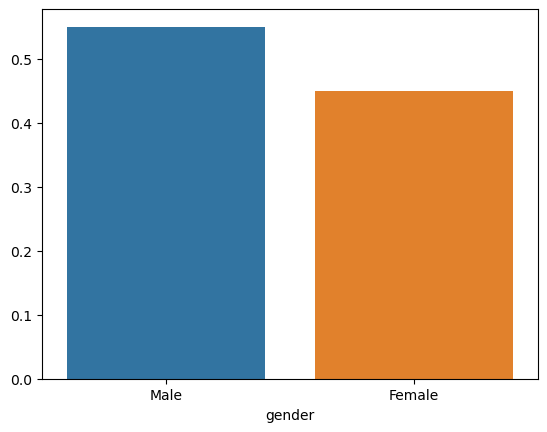

In [31]:
sns.barplot(x = pct_count.index , y = pct_count.values)

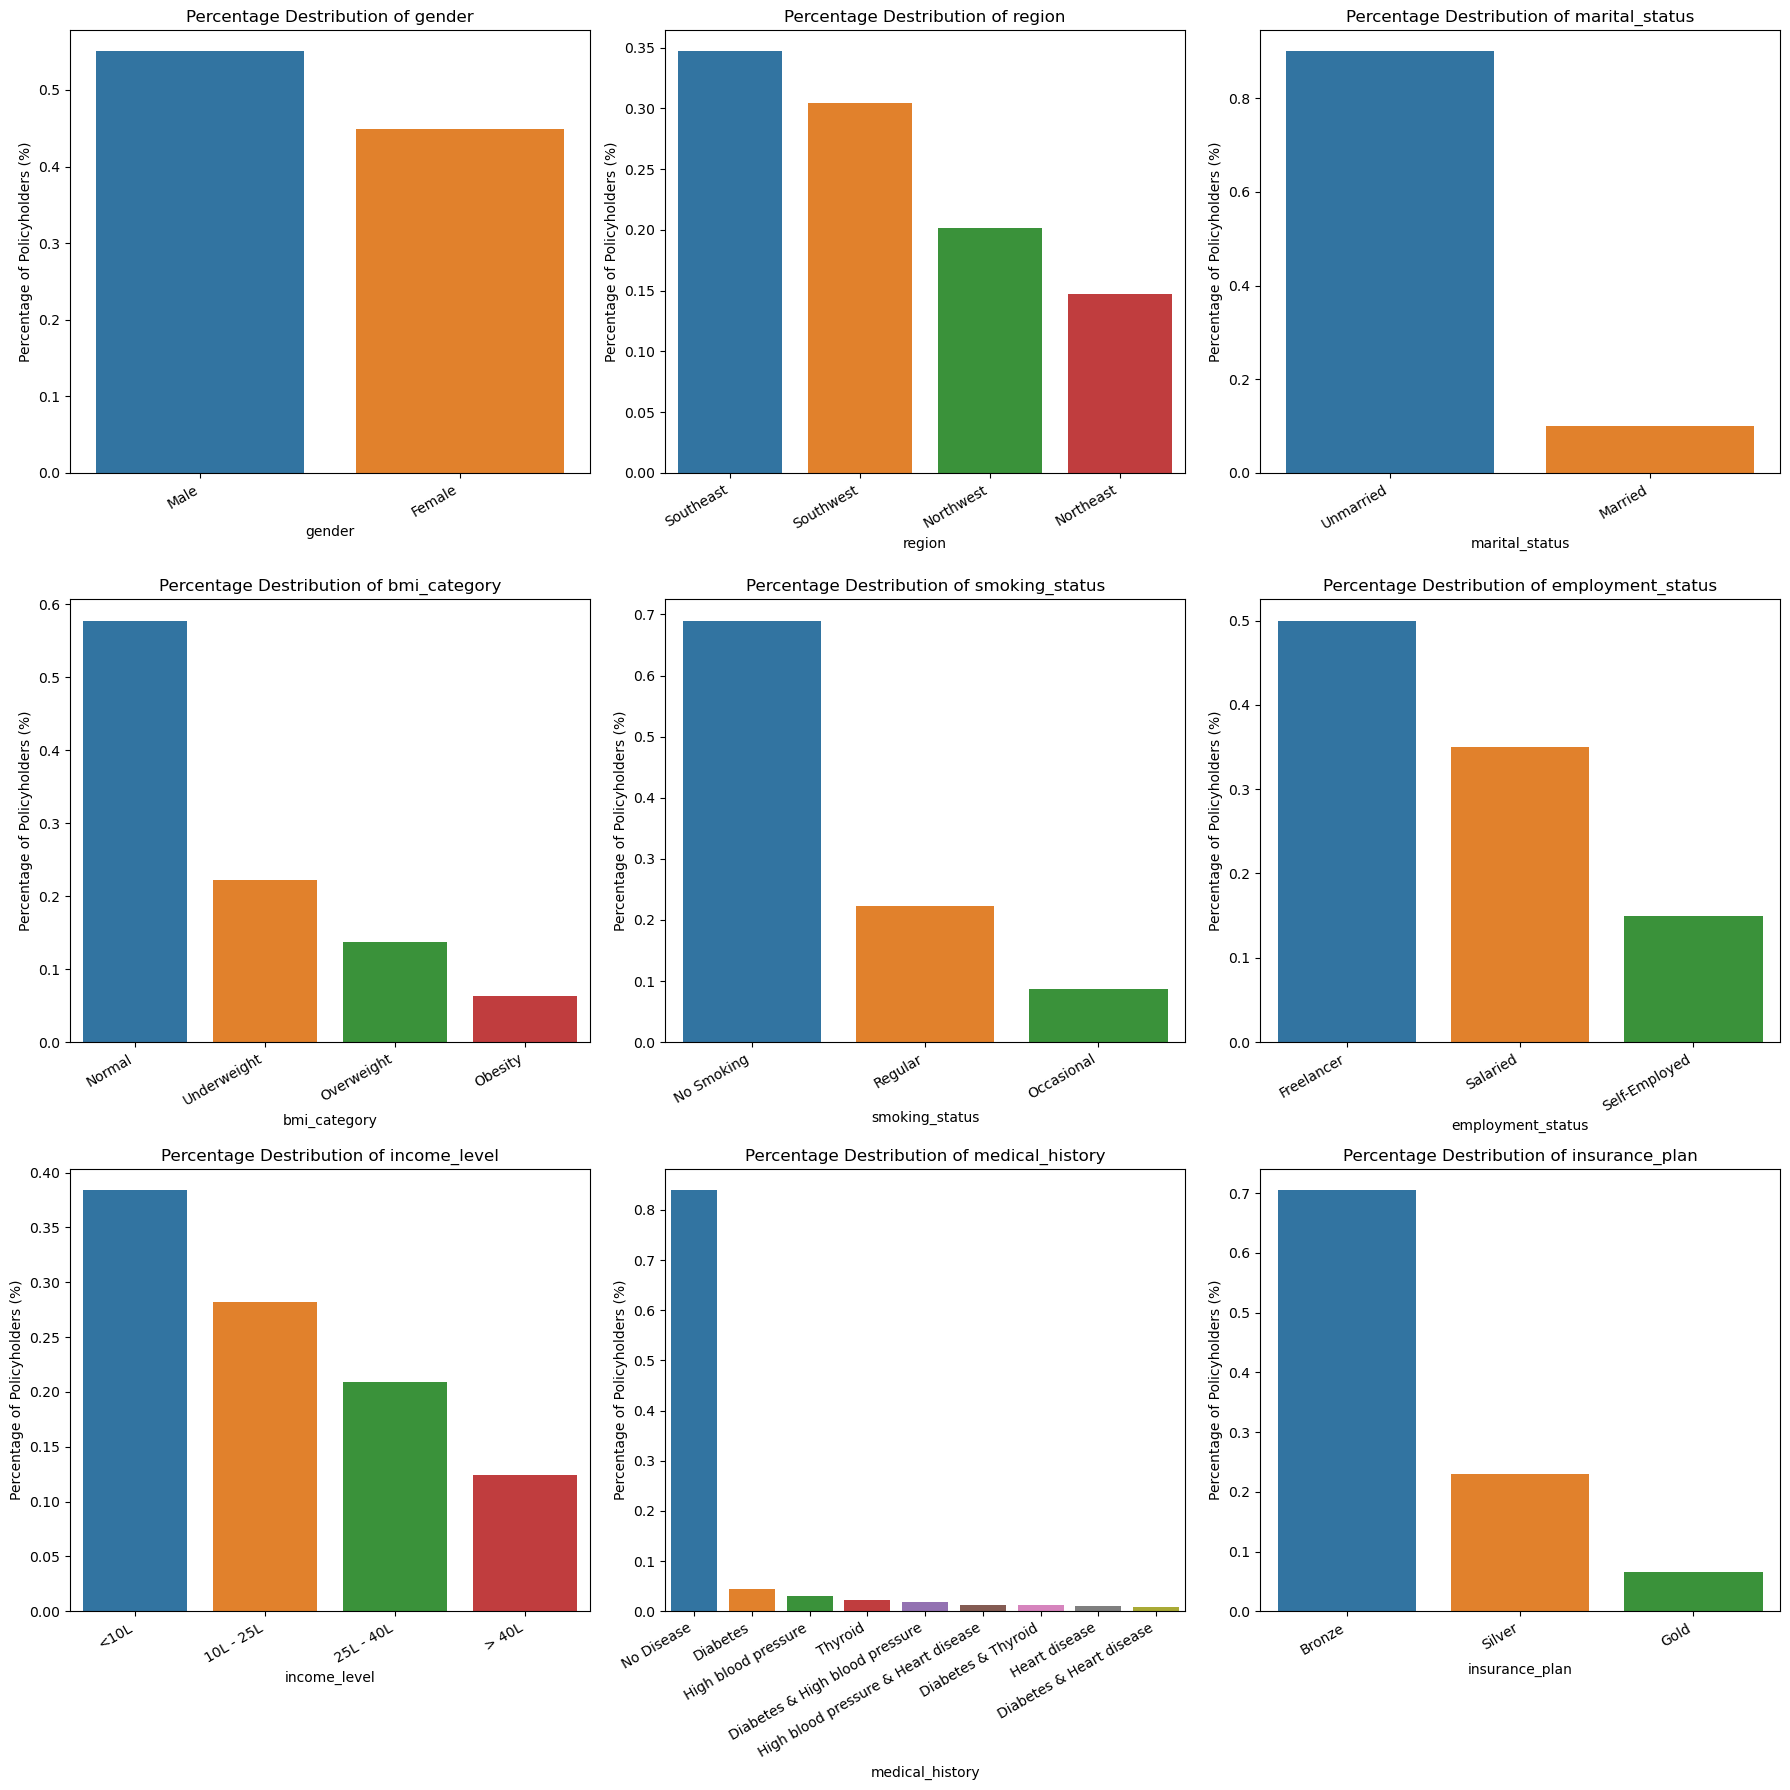

In [32]:
fig , axes = plt.subplots(3,3 , figsize =(18,18))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    pct_count = df2[col].value_counts(normalize = True)
    sns.barplot(x = pct_count.index , y = pct_count.values , ax = axes[i])
    axes[i].set_title(f'Percentage Destribution of {col}')
    axes[i].set_ylabel('Percentage of Policyholders (%)')
    axes[i].set_xlabel(col)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=30, ha="right", fontsize=10)
plt.tight_layout()
plt.show()
    
    

In [33]:
crosstab = pd.crosstab(df2['income_level'] , df2['insurance_plan'])
crosstab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,4508,326,828
25L - 40L,3382,209,608
<10L,6172,404,1145
> 40L,115,366,2023


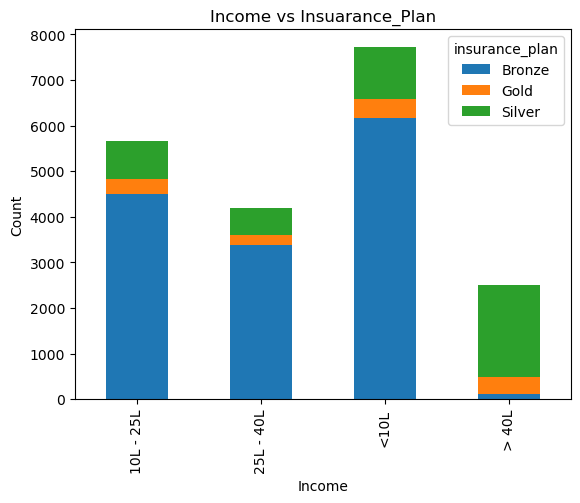

In [34]:
crosstab.plot(kind = 'bar' , stacked = True)
plt.title("Income vs Insuarance_Plan")
plt.ylabel("Count")
plt.xlabel("Income")
plt.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

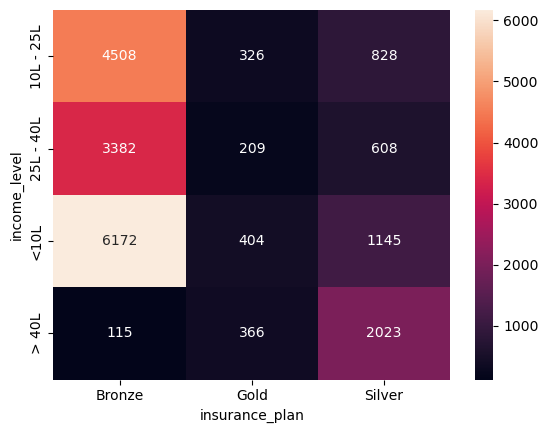

In [35]:
sns.heatmap(crosstab , annot =True , fmt = 'd')

## 2). Feature Engineering

In [36]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050


In [37]:
df2.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [38]:
risk_scores = {
    "diabetes" : 6 , 
    "heart disease":8,
    "high blood pressure" : 6,
    "thyroid" : 5 , 
    "no disease" : 0,
    "none":0
}

df2[['disease1' ,'disease2']] = df2['medical_history'].str.split(" & " , expand = True).apply(lambda x: x.str.lower())
# (split) devide column value by & and (expand) add to two columns
df2.head(2)



,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,None


In [39]:
df2['disease1'].fillna('none' , inplace = True)
df2['disease2'].fillna('none' , inplace = True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)
    
min_score = df2['total_risk_score'].min()
max_score = df2['total_risk_score'].max()
                
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0,0.000000


In [40]:
df2.insurance_plan.unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [41]:
df2["insurance_plan"] = df["insurance_plan"].map({'Bronze' : 1 , 'Silver' : 2 , 'Gold' : 3})
df2["insurance_plan"].unique()

array([2, 1, 3], dtype=int64)

In [42]:
df2["income_level"] = df["income_level"].map({'<10L' : 1 , '10L - 25L':2 , '25L - 40L':3 , '> 40L':4})
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1,3,No Disease,2,11050,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,4,97,No Disease,2,11857,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,2,15,No Disease,1,5684,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,2,14,No Disease,1,5712,no disease,none,0,0.000000


In [43]:
nominal_cols = ['gender','region','marital_status','bmi_category' , 'smoking_status','employment_status']

df3 = pd.get_dummies(df2 , columns = nominal_cols , drop_first=True , dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,no disease,none,0,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,no disease,none,0,...,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,No Disease,1,5684,no disease,none,0,...,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,No Disease,1,5712,no disease,none,0,...,1,0,1,0,1,0,0,0,0,0


In [44]:
df4 = df3.drop(['medical_history' , 'disease1','disease2','total_risk_score'],axis = 1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,1,5684,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,1,5712,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


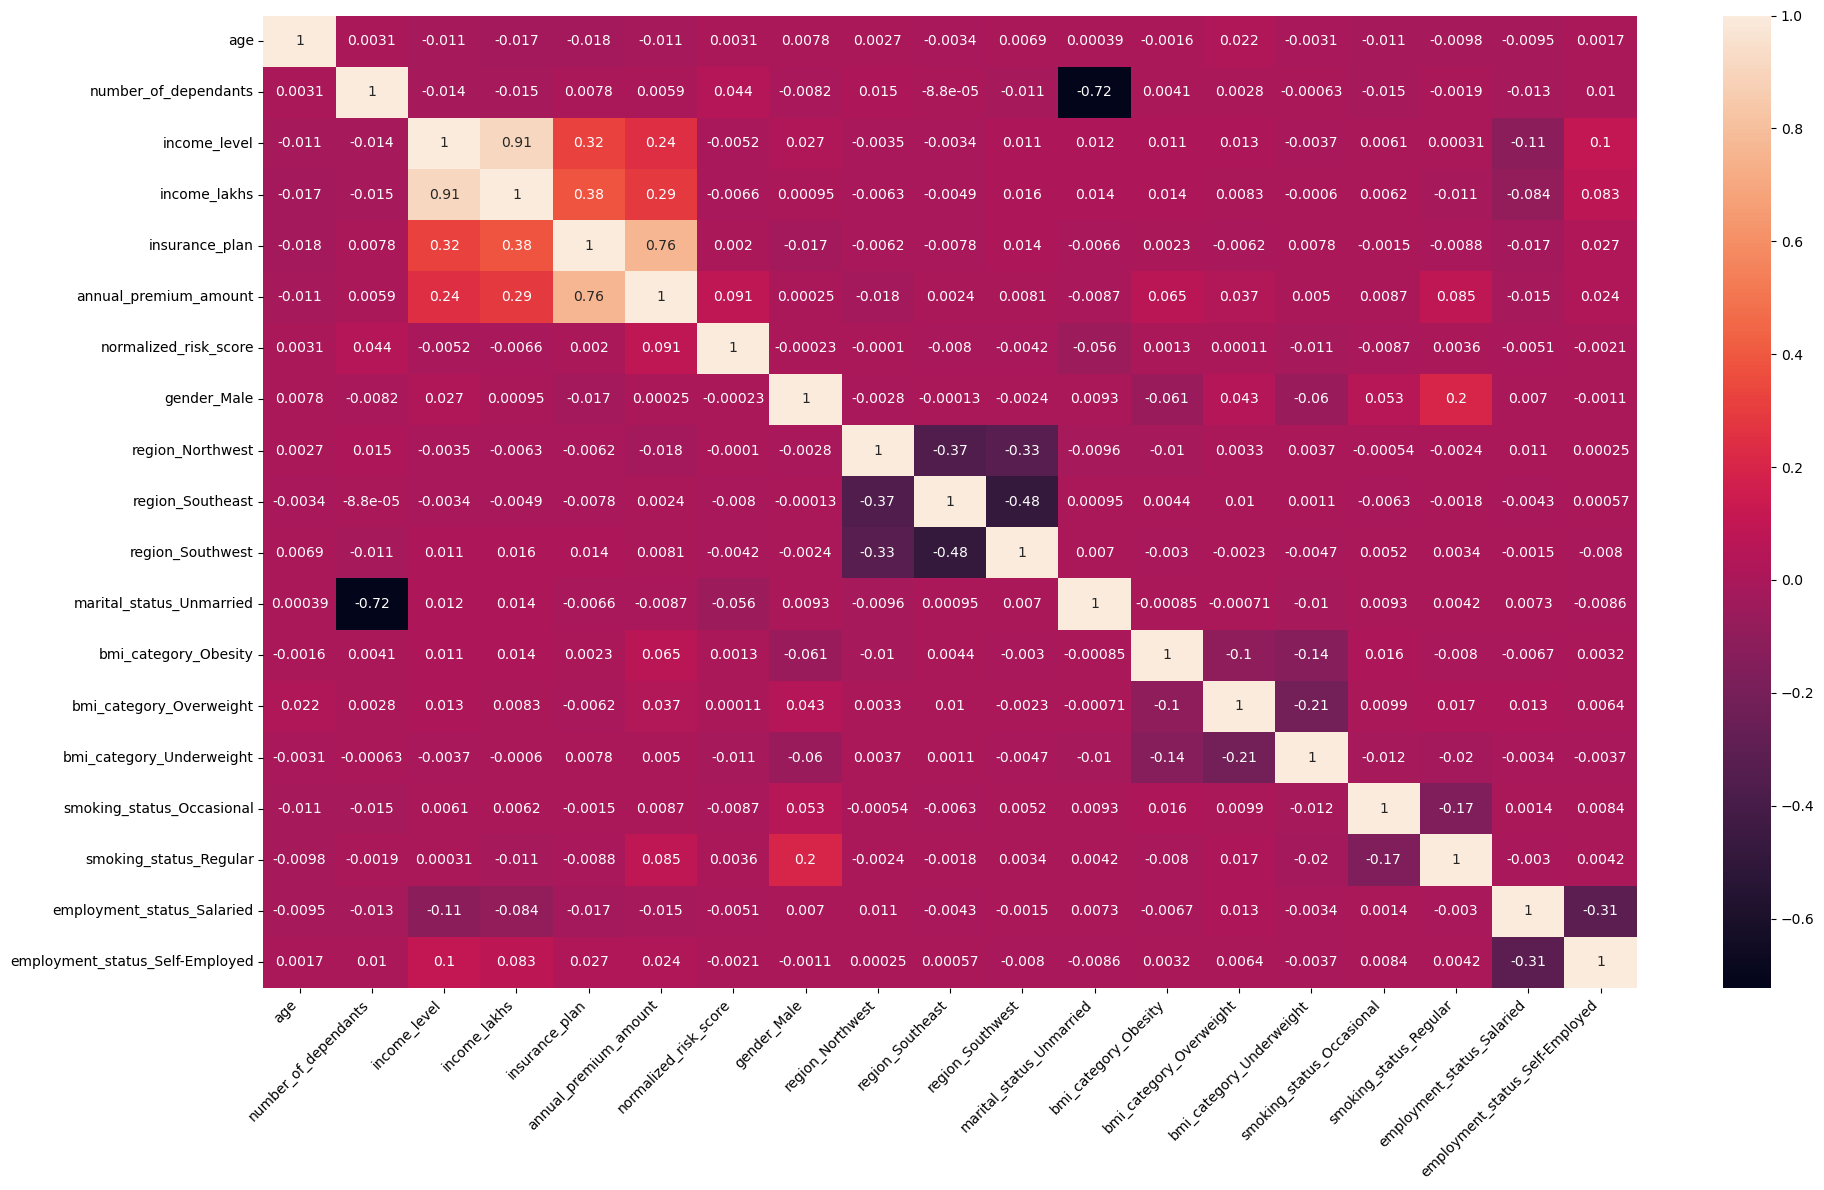

In [45]:
cm = df4.corr()      # correlation matrix

plt.figure(figsize =(20,12))
sns.heatmap(cm , annot = True)
plt.xticks(rotation =45 , ha ='right')
plt.yticks(rotation = 0 )
plt.tight_layout()
plt.show()

In [46]:
X = df4.drop('annual_premium_amount',axis = 1)
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants','income_level','income_lakhs','insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values , i) for i in range(data.shape[1])]
    return vif_df


In [48]:
calculate_vif(X)

,column,VIF
0,age,3.142881
1,number_of_dependants,1.860761
2,income_level,11.928707
3,income_lakhs,11.874242
4,insurance_plan,1.592892
5,normalized_risk_score,1.154223
6,gender_Male,2.310023
7,region_Northwest,2.147701
8,region_Southeast,2.970188
9,region_Southwest,2.730503


In [49]:
calculate_vif(X.drop('income_level',axis = 1))  # two column have vif greater thn 10 , firstly remove highest vif and recheck




,column,VIF
0,age,3.141534
1,number_of_dependants,1.858110
2,income_lakhs,2.291873
3,insurance_plan,1.587794
4,normalized_risk_score,1.154174
5,gender_Male,2.299848
6,region_Northwest,2.146767
7,region_Southeast,2.968993
8,region_Southwest,2.729813
9,marital_status_Unmarried,7.299818


In [50]:
X_reduced = X.drop('income_level',axis = 1)
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


## 3). Model Training

In [51]:
X_train ,X_test , y_train ,y_test = train_test_split(X_reduced , y ,test_size = 0.3 , random_state = 10 )

print("X_train :", X_train.shape)
print("X_test :", X_test.shape)
print("y_train :", y_train.shape)
print("y_test :", y_test.shape)

X_train : (14060, 17)
X_test : (6026, 17)
y_train : (14060,)
y_test : (6026,)


In [52]:
model_lr = LinearRegression()
model_lr.fit(X_train , y_train)

train_score = model_lr.score(X_train , y_train)
test_score = model_lr.score(X_test , y_test)

train_score , test_score

(0.6020471274164894, 0.6047589163893645)

In [53]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test , y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE :", mse_lr , " RMSE : ",rmse_lr)

Linear Regression ==> MSE : 3005669.8791236714  RMSE :  1733.6867880686152


In [54]:
model_lr.intercept_

6614.583391230755

In [55]:
model_lr.coef_

array([ 5.51905147e+01, -1.45039643e+02, -3.60667677e+01,  7.00007042e+03,
        1.11127879e+03,  9.82564766e+00, -1.14273450e+02, -3.64663714e+01,
       -6.72232248e+01, -5.85343424e+01,  7.92952660e+02,  4.35760406e+02,
        1.69728916e+02,  2.44813937e+02,  6.19082947e+02, -1.30535485e+01,
       -4.34272200e+00])

In [56]:
feature_importance = model_lr.coef_

coef_df = pd.DataFrame(feature_importance , index = X_test.columns , columns =['Coefficients'])
coef_df = coef_df.sort_values(by ='Coefficients',ascending = True)
coef_df


,Coefficients
number_of_dependants,-145.039643
region_Northwest,-114.273450
region_Southwest,-67.223225
marital_status_Unmarried,-58.534342
region_Southeast,-36.466371
income_lakhs,-36.066768
employment_status_Salaried,-13.053549
employment_status_Self-Employed,-4.342722
gender_Male,9.825648
age,55.190515


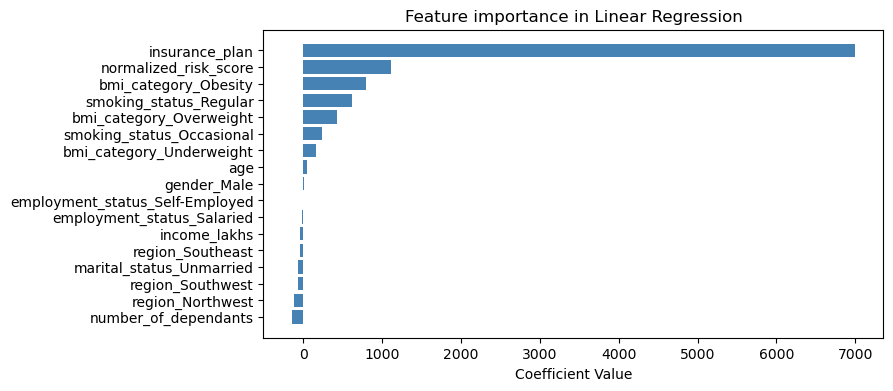

In [57]:
plt.figure(figsize = (8,4))
plt.barh(coef_df.index , coef_df["Coefficients"] , color = 'steelblue')
plt.xlabel('Coefficient Value')
plt.title("Feature importance in Linear Regression")
plt.show()

In [58]:
model_rg = Ridge()
model_rg.fit(X_train , y_train)

train_score = model_rg.score(X_train , y_train)
test_score = model_rg.score(X_test , y_test)

train_score , test_score


(0.6020466631305188, 0.6047715291063814)

In [59]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train , y_train)

train_score = model_xgb.score(X_train , y_train)
test_score = model_xgb.score(X_test , y_test)

train_score , test_score

(0.7251047267247346, 0.5638787808263517)

In [60]:
y_pred = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test , y_pred)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBoost Regression ==> MSE :", mse_xgb , " RMSE : ",rmse_xgb)

XGBoost Regression ==> MSE : 3316548.97851731  RMSE :  1821.1394725603282


In [61]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

In [62]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_


0.5997089124277125

In [63]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

In [86]:
best_model = model_lr

## 4). Error Analysis

In [67]:
# works with test data set

In [68]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = residuals * 100 / y_test

results_df = pd.DataFrame({
    'actual' : y_test,
    'predicated' : y_pred,
    'diff' : residuals,
    'diff_pct' : residuals_pct
})

results_df.head()

,actual,predicated,diff,diff_pct
12774,6238,6669.329590,431.329590,6.914549
14758,9462,6999.429199,-2462.570801,-26.025902
13205,5152,6998.085449,1846.085449,35.832404
14278,6988,7868.310059,880.310059,12.597454
19351,4917,6677.658203,1760.658203,35.807570


<Axes: xlabel='diff_pct', ylabel='Count'>

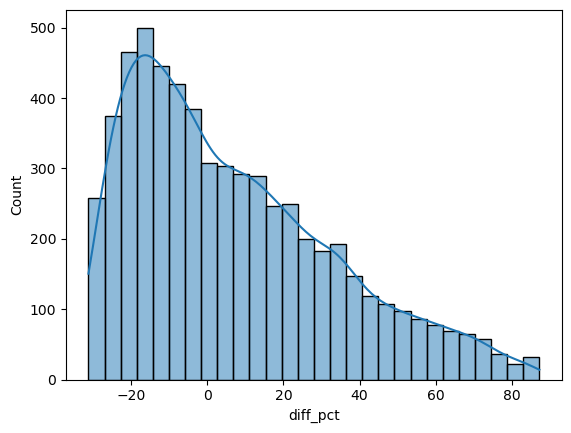

In [69]:
sns.histplot(results_df['diff_pct'] , kde = True)

In [70]:
extreme_error_threshold = 10        # our maximum error percentage is 10

extreme_results_df = results_df[np.abs(results_df.diff_pct) > extreme_error_threshold]
extreme_results_df

,actual,predicated,diff,diff_pct
14758,9462,6999.429199,-2462.570801,-26.025902
13205,5152,6998.085449,1846.085449,35.832404
14278,6988,7868.310059,880.310059,12.597454
19351,4917,6677.658203,1760.658203,35.807570
10622,8947,7154.854492,-1792.145508,-20.030686
...,...,...,...,...
399,8673,7575.317871,-1097.682129,-12.656314
17652,7635,6585.947754,-1049.052246,-13.740043
5807,4845,7057.350098,2212.350098,45.662541
10298,13866,10994.864258,-2871.135742,-20.706301


In [71]:
results_df.shape    

(6026, 4)

In [72]:
extreme_errors_pct = extreme_results_df.shape[0] * 100 / results_df.shape[0]
extreme_errors_pct

73.13308994357783

In [73]:
# it means 73% of predictions , error is higher than 10% ( on test data)

In [74]:
extreme_results_df_50 = results_df[np.abs(results_df.diff_pct) > 50]
extreme_errors_pct_50 = extreme_results_df.shape[0] * 100 / results_df.shape[0]
extreme_results_df_50.shape[0] , extreme_errors_pct_50

(522, 73.13308994357783)

In [75]:
# it mean 549 data rows of test data have error grater than 50%

In [76]:
extreme_results_df.index     # indexes of test records that have error graer than 10%


Index([14758, 13205, 14278, 19351, 10622, 14799, 16348,  5573,  5634, 14882,
       ...
        5484,  8988,  8695,  9658,  1365,   399, 17652,  5807, 10298, 13316],
      dtype='int64', length=4407)

In [77]:
extreme_errors_df = X_test.loc[extreme_results_df.index]  #  test records that have error grater than 10%
extreme_errors_df




,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14758,0.285714,0.000000,0.060606,0.0,0.000000,0,0,0,1,1,0,0,0,0,1,0,1
13205,0.714286,0.333333,0.141414,0.0,0.000000,1,1,0,0,1,0,0,0,0,1,0,1
14278,0.714286,0.333333,0.222222,0.0,0.000000,1,0,1,0,1,1,0,0,0,1,0,0
19351,0.571429,0.000000,0.101010,0.0,0.000000,1,0,0,1,1,0,0,1,0,0,0,0
10622,0.428571,0.333333,0.050505,0.0,0.357143,0,0,1,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.142857,0.666667,0.111111,0.0,0.785714,0,0,0,1,1,0,0,1,0,0,1,0
17652,0.571429,0.000000,0.343434,0.0,0.000000,1,0,0,0,1,0,0,0,0,0,1,0
5807,0.857143,0.333333,0.040404,0.0,0.000000,1,1,0,0,1,0,0,0,0,1,0,0
10298,0.000000,0.000000,0.111111,0.5,0.000000,1,0,1,0,1,0,1,0,0,1,1,0


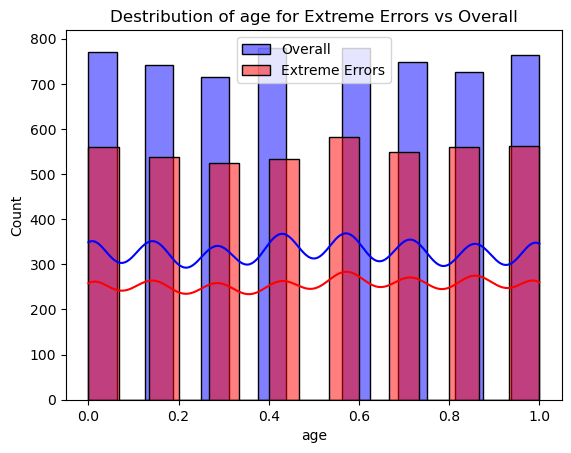

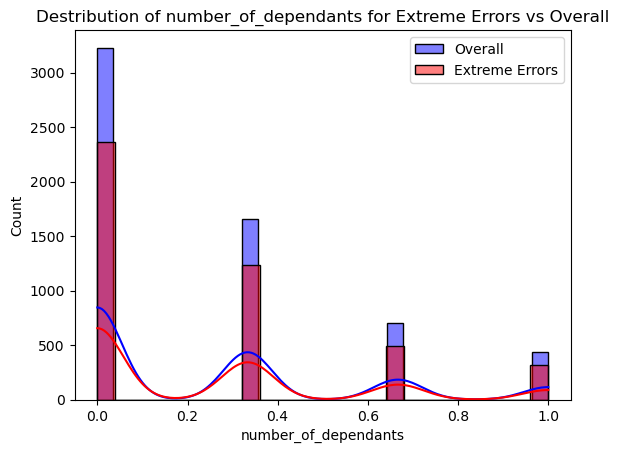

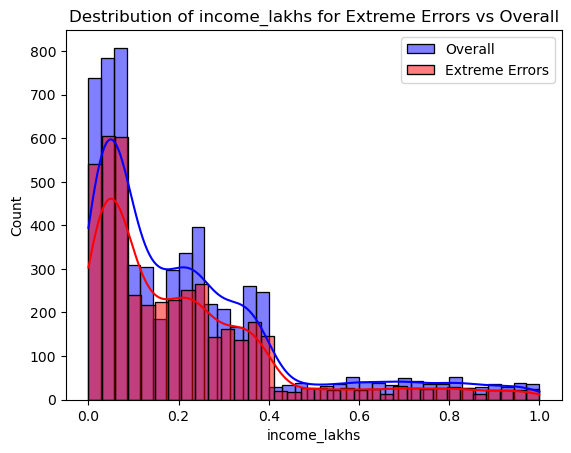

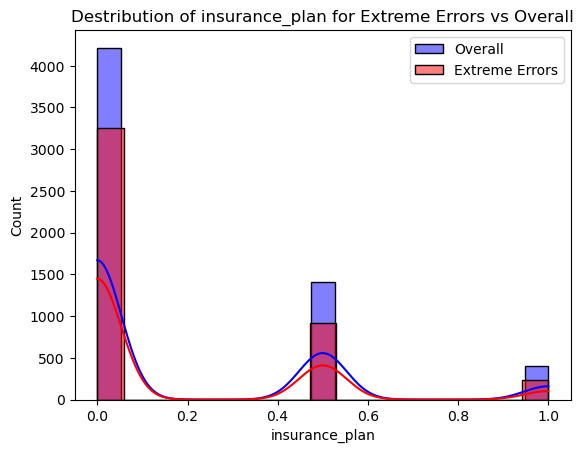

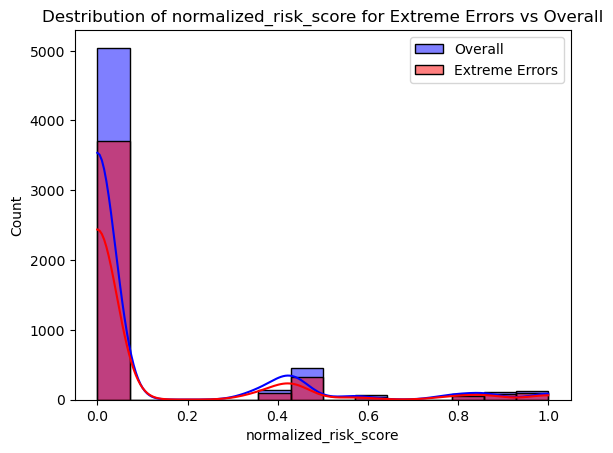

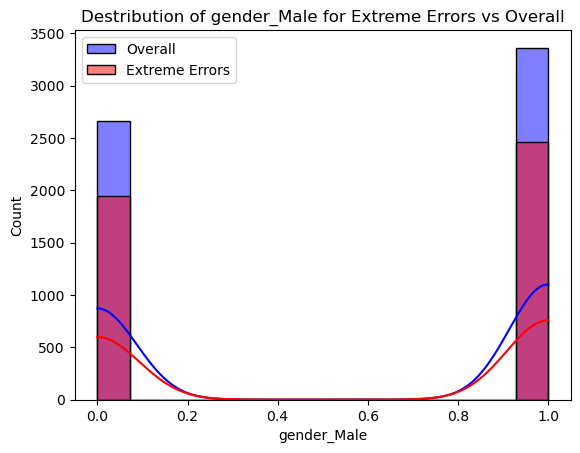

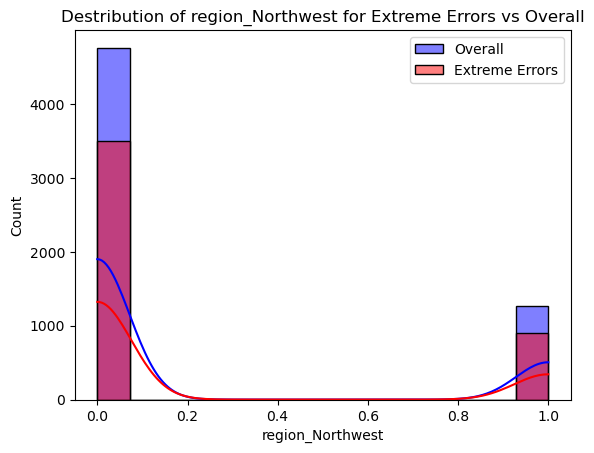

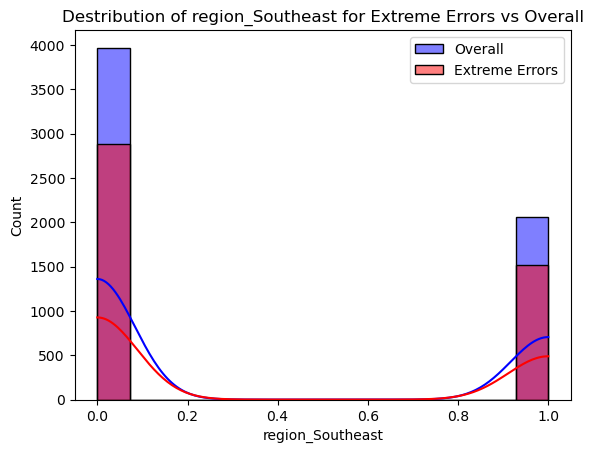

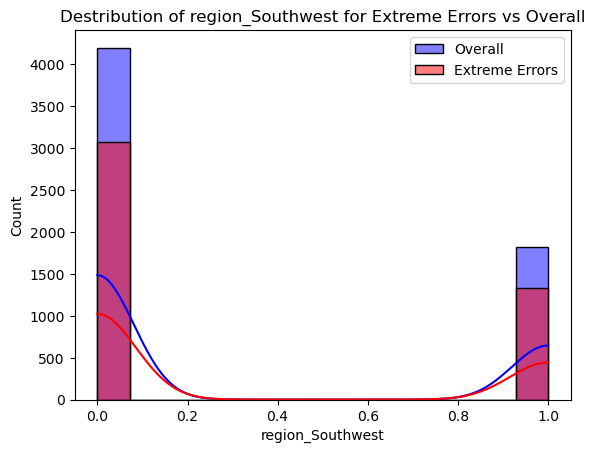

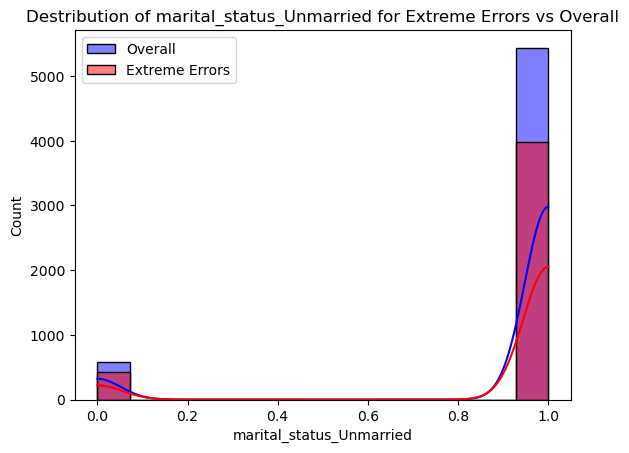

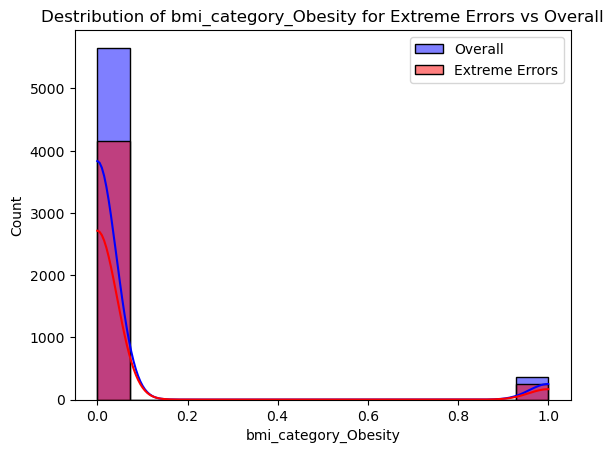

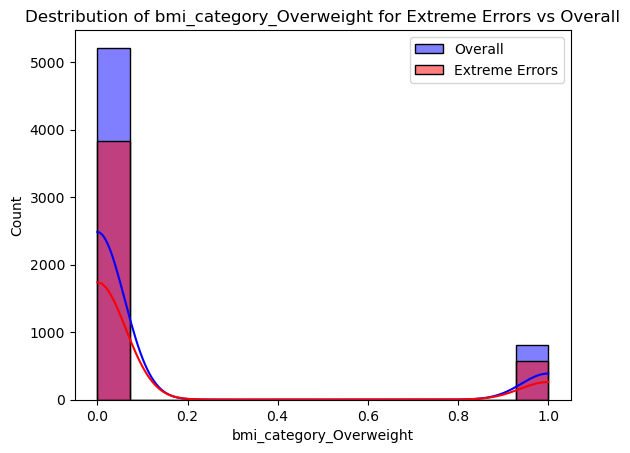

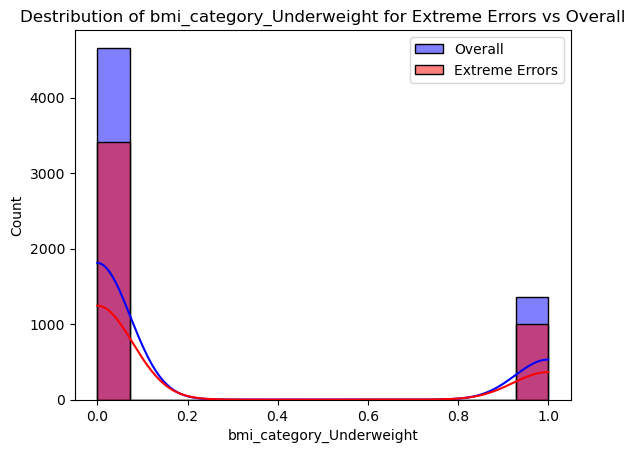

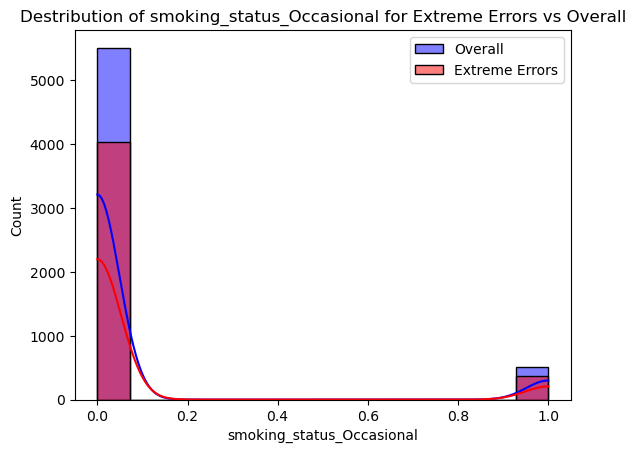

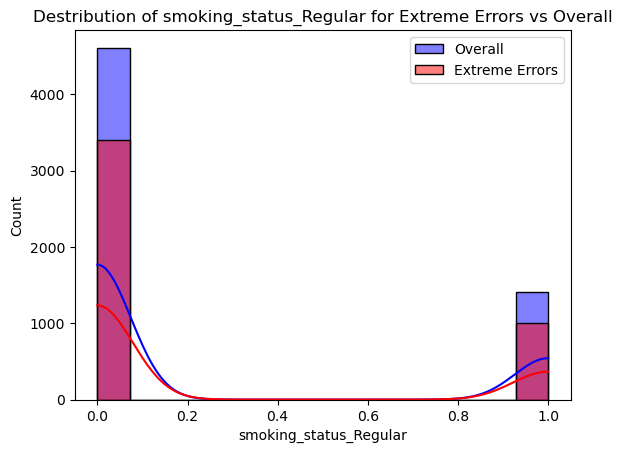

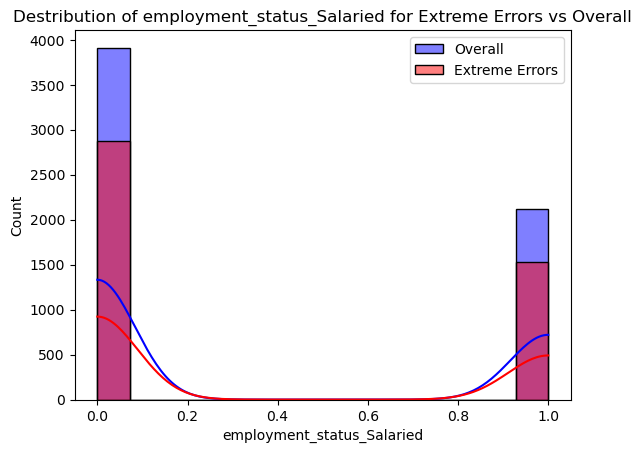

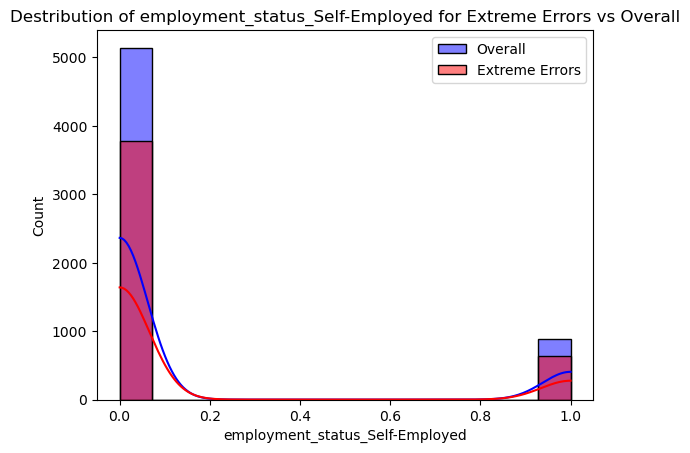

In [78]:
for col in X_test.columns:
    sns.histplot(X_test[col] ,label = "Overall",color = 'blue', kde = True)
    sns.histplot(extreme_errors_df[col] ,label = "Extreme Errors",color ='red', kde = True)
    plt.title(f'Destribution of {col} for Extreme Errors vs Overall')
    plt.legend()
    plt.show()
        

In [79]:
# insight : problem with lower age group

<Axes: xlabel='age', ylabel='Count'>

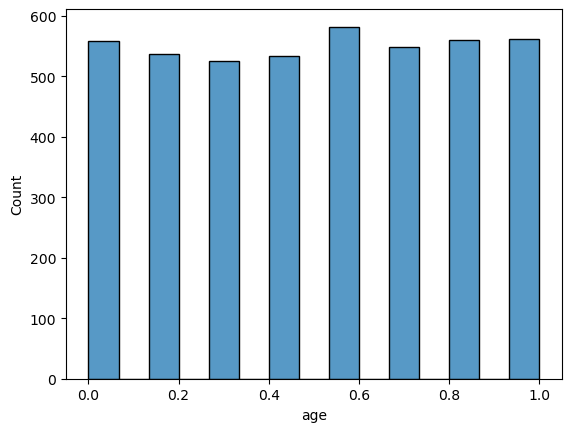

In [80]:
sns.histplot(extreme_errors_df.age)

In [81]:
# we want see real ages  , going to reversed that , scaled data before


df_reversed = pd.DataFrame()

extreme_errors_df['income_level'] = -1    # we want add because we doped that column after scaling
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed





,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,20.0,0.0,-2.0,7.0,1.0
1,23.0,1.0,-2.0,15.0,1.0
2,23.0,1.0,-2.0,23.0,1.0
3,22.0,0.0,-2.0,11.0,1.0
4,21.0,1.0,-2.0,6.0,1.0
...,...,...,...,...,...
4402,19.0,2.0,-2.0,12.0,1.0
4403,22.0,0.0,-2.0,35.0,1.0
4404,24.0,1.0,-2.0,5.0,1.0
4405,18.0,0.0,-2.0,12.0,2.0


<Axes: xlabel='age', ylabel='Count'>

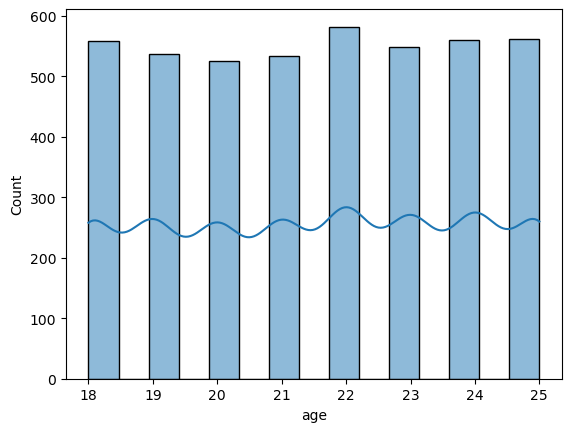

In [82]:
sns.histplot(df_reversed['age'] , kde =True)

In [83]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4407.000000,4407.000000,4407.0,4407.000000,4407.000000
mean,21.529158,0.719083,-2.0,21.531881,1.313592
std,2.298631,0.925042,0.0,20.973262,0.565424
min,18.000000,0.000000,-2.0,1.000000,1.000000
25%,20.000000,0.000000,-2.0,6.000000,1.000000
50%,22.000000,0.000000,-2.0,15.000000,1.000000
75%,24.000000,1.000000,-2.0,30.000000,2.000000
max,25.000000,3.000000,-2.0,100.000000,3.000000


In [84]:
for i in np.arange(0.75, 1.0, 0.01):
    qv = (round(i, 2))
    print(f"Quantile : {qv}   Age up to : {df_reversed['age'].quantile(qv)}")

Quantile : 0.75   Age up to : 24.0
Quantile : 0.76   Age up to : 24.0
Quantile : 0.77   Age up to : 24.0
Quantile : 0.78   Age up to : 24.0
Quantile : 0.79   Age up to : 24.0
Quantile : 0.8   Age up to : 24.0
Quantile : 0.81   Age up to : 24.0
Quantile : 0.82   Age up to : 24.0
Quantile : 0.83   Age up to : 24.0
Quantile : 0.84   Age up to : 24.0
Quantile : 0.85   Age up to : 24.0
Quantile : 0.86   Age up to : 24.0
Quantile : 0.87   Age up to : 24.0
Quantile : 0.88   Age up to : 25.0
Quantile : 0.89   Age up to : 25.0
Quantile : 0.9   Age up to : 25.0
Quantile : 0.91   Age up to : 25.0
Quantile : 0.92   Age up to : 25.0
Quantile : 0.93   Age up to : 25.0
Quantile : 0.94   Age up to : 25.0
Quantile : 0.95   Age up to : 25.0
Quantile : 0.96   Age up to : 25.0
Quantile : 0.97   Age up to : 25.0
Quantile : 0.98   Age up to : 25.0
Quantile : 0.99   Age up to : 25.0


In [85]:
# insight : 95 % of extreme error records have age 25 or less